## Imports

In [2]:
#!/usr/bin/env python

# Standard libraries
import os
import sys

# Numerical and data processing libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Custom libraries
from libs.paths import results_folder
from libs.label_mappings import get_label_meaning

## Input Files

In [3]:
# # Input files

signal_x = 'ECG'
signal_y = 'PCG'
label_x = 2  # Replace with your chosen label for x
label_y = 2  # Replace with your chosen label for y

label_string,_,_ = get_label_meaning(signal_x,signal_y, label_x, label_y)

print(label_string)  # Output: 'S1S2' for PCG, 'baseline segmento QRS' for ECG

# Load Estimates
estimates_file_path = results_folder / f"{label_string}_estimates_and_annotations.csv"
df = pd.read_pickle(estimates_file_path)  # Use read_csv instead of read_pickle for CSV files

print(df.columns)


QS2
Index(['ID', 'Auscultation Point', 'Q', 'S2', 'Intervals_start_times',
       'Intervals_end_times', 'Intervals_mid_times',
       'Filtered_Intervals_start_times', 'Filtered_Intervals_end_times',
       'Filtered_Intervals_mid_times', 'Avg_Filtered_Intervals_start_times',
       'Avg_Filtered_Intervals_end_times', 'Avg_Filtered_Intervals_mid_times',
       'Status_of_EF', 'HR (Heart rate)', 'QS2'],
      dtype='object')


## Filter Intervals Effetc

In [4]:
import pandas as pd

# Assuming your dataframe is called df
df['num_intervals_start'] = df['Intervals_start_times'].apply(len)
df['num_intervals_mid'] = df['Intervals_mid_times'].apply(len)
df['num_intervals_end'] = df['Intervals_end_times'].apply(len)

# View the number of intervals for each signal
# df[['num_intervals_start', 'num_intervals_mid', 'num_intervals_end']]


In [5]:
# Calculate the number of filtered intervals for each signal
df['num_filtered_intervals_start'] = df['Filtered_Intervals_start_times'].apply(len)
df['num_filtered_intervals_mid'] = df['Filtered_Intervals_mid_times'].apply(len)
df['num_filtered_intervals_end'] = df['Filtered_Intervals_end_times'].apply(len)

# View the number of filtered intervals for each signal
# df[['num_filtered_intervals_start', 'num_filtered_intervals_mid', 'num_filtered_intervals_end']]

In [6]:
# Calculate the percentage removed for each signal
df['percentage_removed'] = 100 * (df['num_intervals_start'] - df['num_filtered_intervals_start']) / df['num_intervals_start']

# Sort by the percentage removed to find signals with the highest removal
sorted_df = df[['ID', 'percentage_removed']].sort_values(by='percentage_removed', ascending=False)

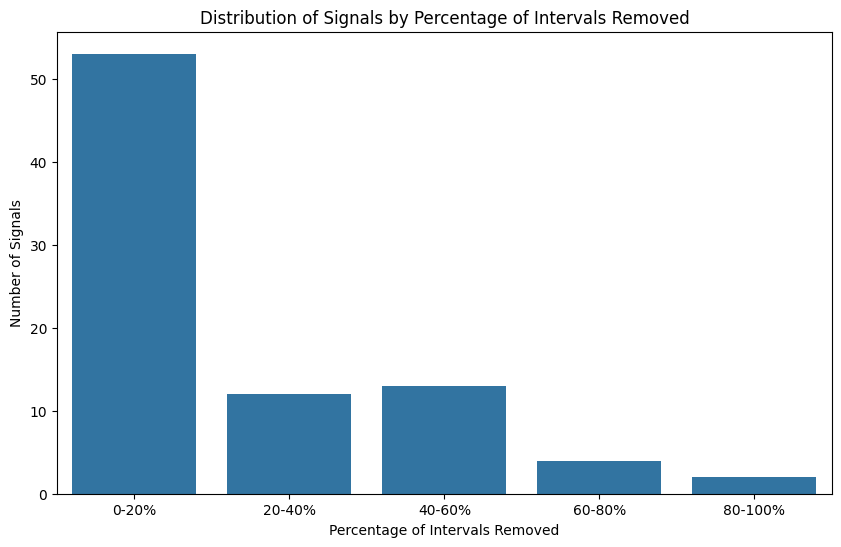

<Figure size 640x480 with 0 Axes>

In [7]:
# Define the bins for percentage removal
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']

# Assign each signal to a bin based on the percentage removed
df['removal_bin'] = pd.cut(df['percentage_removed'], bins=bins, labels=labels, right=False)

# Count the number of signals in each bin
removal_counts = df['removal_bin'].value_counts().sort_index()

# Plotting the distribution of signals across the bins
plt.figure(figsize=(10, 6))
sns.barplot(x=removal_counts.index, y=removal_counts.values)
plt.title('Distribution of Signals by Percentage of Intervals Removed')
plt.xlabel('Percentage of Intervals Removed')
plt.ylabel('Number of Signals')
plt.show()
# Save the plot
plt.savefig(f"{label_string}_Removed_Intervals.png")  # Save as PNG

plt.show()


<Figure size 1000x600 with 0 Axes>

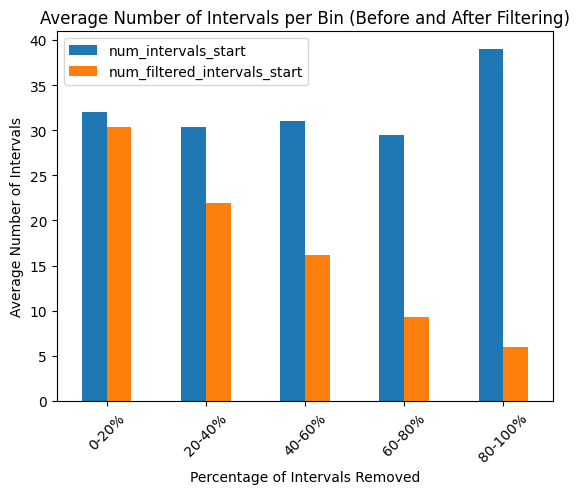

In [8]:
# Calculate the average number of intervals for each bin, with observed=False to avoid the warning
bin_avg_intervals = df.groupby('removal_bin', observed=False)[['num_intervals_start', 'num_filtered_intervals_start']].mean()

# Plotting the average number of intervals for each bin
plt.figure(figsize=(10, 6))
bin_avg_intervals[['num_intervals_start', 'num_filtered_intervals_start']].plot(kind='bar')
plt.title('Average Number of Intervals per Bin (Before and After Filtering)')
plt.xlabel('Percentage of Intervals Removed')
plt.ylabel('Average Number of Intervals')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Find signals with NaN values in any of the relevant columns
nan_signals = df[df[['Avg_Filtered_Intervals_start_times', 'Avg_Filtered_Intervals_mid_times', 'Avg_Filtered_Intervals_end_times']].isna().any(axis=1)]

# Extract the list of signal identifiers (replace 'Signal_ID' with the actual column name that identifies each signal)
nan_signal_ids = nan_signals['ID'].unique()  # or whatever column is the signal identifier

nan_signal_ids

<IntegerArray>
[]
Length: 0, dtype: Int64

## True vs Estimated S1S2

In [10]:
# Create a copy of the original dataframe to work with
df_cleaned = df.copy()

# Fill NaN values in specific columns with the median of the column in df_cleaned
df_cleaned['Avg_Filtered_Intervals_start_times'] = df_cleaned['Avg_Filtered_Intervals_start_times'].fillna(df_cleaned['Avg_Filtered_Intervals_start_times'].median())
df_cleaned['Avg_Filtered_Intervals_mid_times'] = df_cleaned['Avg_Filtered_Intervals_mid_times'].fillna(df_cleaned['Avg_Filtered_Intervals_mid_times'].median())
df_cleaned['Avg_Filtered_Intervals_end_times'] = df_cleaned['Avg_Filtered_Intervals_end_times'].fillna(df_cleaned['Avg_Filtered_Intervals_end_times'].median())

# Define the interval labels
intervals = ["start", "mid", "end"]

# Initialize a dictionary to store metrics
metrics = {}

# Loop through each interval type and compute the metrics
for interval in intervals:
    # Ensure that 'label_string' is defined correctly (replace 'label_string' with the actual column name if necessary)
    mae = mean_absolute_error(df_cleaned[f'{label_string}'], df_cleaned[f'Avg_Filtered_Intervals_{interval}_times'])
    mse = mean_squared_error(df_cleaned[f'{label_string}'], df_cleaned[f'Avg_Filtered_Intervals_{interval}_times'])
    r2 = r2_score(df_cleaned[f'{label_string}'], df_cleaned[f'Avg_Filtered_Intervals_{interval}_times'])

    # Store the results in the metrics dictionary
    metrics[f'MAE ({interval.capitalize()})'] = mae
    metrics[f'MSE ({interval.capitalize()})'] = mse
    metrics[f'R² ({interval.capitalize()})'] = r2

# Display the results
metrics

{'MAE (Start)': 25.38171813517097,
 'MSE (Start)': 1792.2259044138482,
 'R² (Start)': -0.20802841282966678,
 'MAE (Mid)': 29.236092684489456,
 'MSE (Mid)': 1902.415733547862,
 'R² (Mid)': -0.2823005478718559,
 'MAE (End)': 33.84064096663502,
 'MSE (End)': 2144.562758120811,
 'R² (End)': -0.44551685059679347}

In [11]:
df_cleaned = df.dropna(subset=['Avg_Filtered_Intervals_start_times'])

In [12]:
# Count how many signals have Status_of_EF equal to 1
status_1_count = df_cleaned[df_cleaned['Status_of_EF'] == 1].shape[0]

# Print the result
print(f'Number of signals with Status 1: {status_1_count}')

Number of signals with Status 1: 4


In [13]:
df_cleaned = df_cleaned.copy()  # Ensure df_cleaned is a separate copy

df_cleaned['error_start'] = abs(df_cleaned['Avg_Filtered_Intervals_start_times'] - df_cleaned[f'{label_string}'])

# Group by 'removal_bin' and calculate the mean error for Avg_intervals_start
bin_avg_error_start = df_cleaned.groupby('removal_bin', observed=True)['error_start'].mean()

# Display the result
bin_avg_error_start

removal_bin
0-20%      15.886768
20-40%     14.061084
40-60%     47.602276
60-80%     82.100758
80-100%    87.050000
Name: error_start, dtype: float64

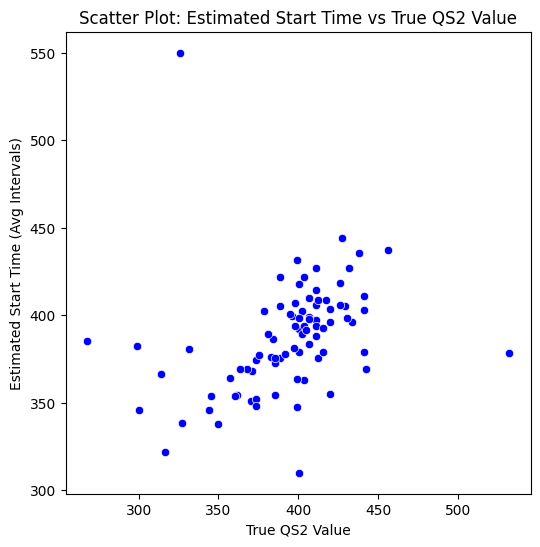

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot comparing the estimated start time intervals with the true S1S2 values
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df_cleaned[f'{label_string}'], y=df_cleaned['Avg_Filtered_Intervals_start_times'], color='blue')
plt.title(f'Scatter Plot: Estimated Start Time vs True {label_string} Value')
plt.xlabel(f'True {label_string} Value')
plt.ylabel('Estimated Start Time (Avg Intervals)')
plt.show()
# Save the plot
plt.savefig(f"{label_string}_True_vs_Est_Corr.png")  # Save as PNG

plt.show()

In [22]:
from scipy.stats import pearsonr

# Calculate Pearson correlation between S1S2 (True) and Avg_intervals_start (Estimated)
corr_stat, p_value_corr = pearsonr(df_cleaned[f'{label_string}'], df_cleaned['Avg_Filtered_Intervals_start_times'])

# Print the correlation results
print(f'Pearson Correlation Coefficient: {corr_stat:.3f}')
print(f'p-value: {p_value_corr:.3f}')

Pearson Correlation Coefficient: 0.301
p-value: 0.005


In [23]:
from scipy.stats import spearmanr

# Calculate Spearman's correlation between S1S2 (True) and Avg_intervals_start (Estimated)
corr_stat_spearman, p_value_spearman = spearmanr(df_cleaned[f'{label_string}'], df_cleaned['Avg_Filtered_Intervals_start_times'])

# Print the correlation results
print(f'Spearman Correlation Coefficient: {corr_stat_spearman:.3f}')
print(f'p-value: {p_value_spearman:.3f}')

Spearman Correlation Coefficient: 0.554
p-value: 0.000


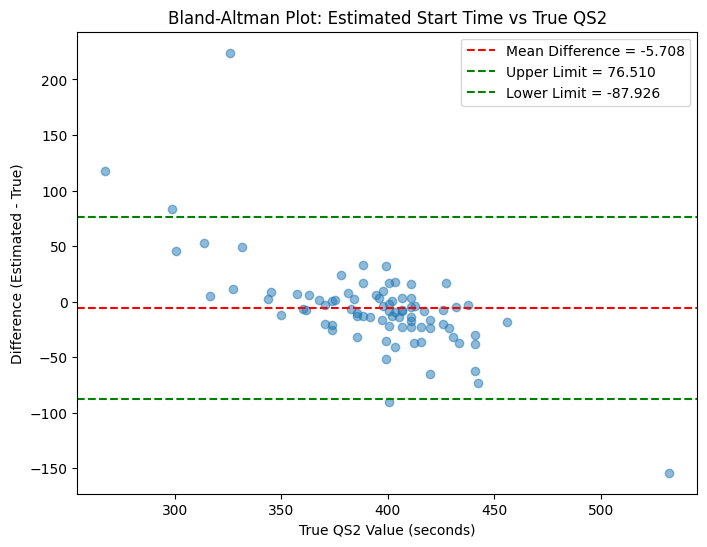

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Bland-Altman plot comparing the estimated start times and true values (S1S2)
mean_diff = np.mean(df_cleaned['Avg_Filtered_Intervals_start_times'] - df_cleaned[f'{label_string}'])
std_diff = np.std(df_cleaned['Avg_Filtered_Intervals_start_times'] - df_cleaned[f'{label_string}'])

# Plot the Bland-Altman
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[f'{label_string}'], df_cleaned['Avg_Filtered_Intervals_start_times'] - df_cleaned[f'{label_string}'], alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Difference = {mean_diff:.3f}')
plt.axhline(mean_diff + 1.96*std_diff, color='green', linestyle='--', label=f'Upper Limit = {mean_diff + 1.96*std_diff:.3f}')
plt.axhline(mean_diff - 1.96*std_diff, color='green', linestyle='--', label=f'Lower Limit = {mean_diff - 1.96*std_diff:.3f}')
plt.title(f'Bland-Altman Plot: Estimated Start Time vs True {label_string}')
plt.xlabel(f'True {label_string} Value (seconds)')
plt.ylabel('Difference (Estimated - True)')
plt.legend()
plt.show()


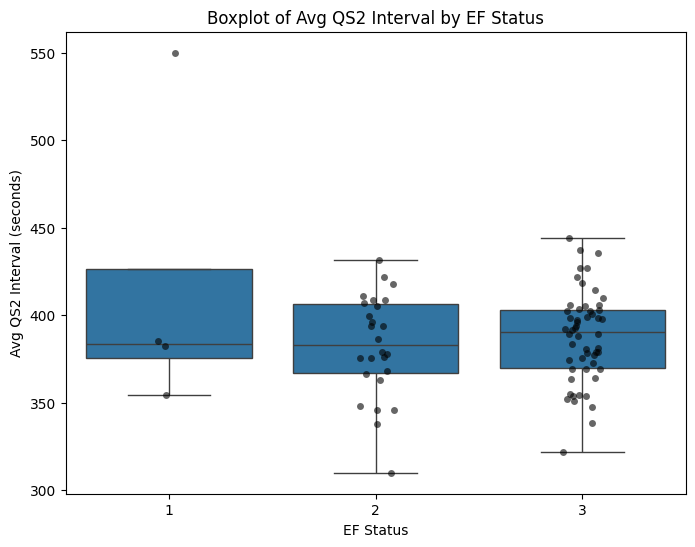

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot for Avg_intervals_start across Status_of_EF with individual points
plt.figure(figsize=(8, 6))
sns.boxplot(x='Status_of_EF', y='Avg_Filtered_Intervals_start_times', data=df_cleaned, showfliers=False)
sns.stripplot(x='Status_of_EF', y='Avg_Filtered_Intervals_start_times', data=df_cleaned, color='black', alpha=0.6, jitter=True)

# Set plot title and labels
plt.title(f'Boxplot of Avg {label_string} Interval by EF Status')
plt.xlabel('EF Status')
plt.ylabel(f'Avg {label_string} Interval (seconds)')
plt.show()

In [19]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis test for Avg_intervals_start against EF Status
groups = [df_cleaned[df_cleaned['Status_of_EF'] == group]['Avg_Filtered_Intervals_start_times'] for group in df_cleaned['Status_of_EF'].unique()]
kruskal_stat, p_value = kruskal(*groups)

# Print the test result
print(f'Kruskal-Wallis Test Statistic: {kruskal_stat:.3f}')
print(f'p-value: {p_value:.3f}')

# Based on the p-value, we can determine if the average intervals differ significantly across EF categories

Kruskal-Wallis Test Statistic: 0.305
p-value: 0.859


In [20]:
from scipy.stats import mannwhitneyu

# Get data for Status_of_EF 1 and 3
status_1 = df_cleaned[df_cleaned['Status_of_EF'] == 1]['Avg_Filtered_Intervals_start_times']
status_3 = df_cleaned[df_cleaned['Status_of_EF'] == 3]['Avg_Filtered_Intervals_start_times']

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(status_1, status_3)

# Print the results
print(f'Mann-Whitney U Test Statistic: {stat:.3f}')
print(f'p-value: {p_value:.3f}')


Mann-Whitney U Test Statistic: 108.000
p-value: 1.000
